# Employee Attrition Prediction (HR) - Salifort Motors

## Model Building and Evaluation

This notebook focuses on building and evaluating machine learning models based on **Decision Tree and Random Forest** algorithms to **predict employee attrition**.
We will preprocess the data, train both models, and compare their performance using relevant classification metrics. The aim is to leverage the interpretability of Decision Trees and the predictive strength of Random Forests to identify key factors influencing employee turnover and build an accurate prediction model

## Tree-based Models - Data Preprocessing

### Library Imports

In [44]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import XGBRFRegressor
from xgboost import plot_importance

# Metrics and Functions
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
 f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# for saving models
import pickle

### Load dataset

We use the encoded dataset from the 'MLmodel_LogisticRegression_Salifort_Motors' notebook.

In [16]:
df = pd.read_csv('Salifort_Motors_HR_dataset_encoded.csv')

### Outcome variable and Features

In [17]:
# Isolate outcome variable
y = df['left']

# Select the features
X = df.drop('left', axis=1)

### Split Data

In [18]:
# Split data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## **Model 1: Decision Tree**

This section focuses on building a Decision Tree model and optimizing its performance using cross-validated grid search.
By exhaustively searching across a defined parameter grid, we aim to identify the best combination of hyperparameters that improve the model's predictive power and generalizability.

### Construct model and GridSearch

In [19]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf':[2, 5, 1],
             'min_samples_split':[2, 4, 6]
             }

# Assign a dictionary of scoring metrics
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'
           }

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

### Fit model

In [20]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 5.84 s, sys: 4.83 ms, total: 5.85 s
Wall time: 6.07 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

### Check Parameters & Metrics

In [21]:
# Check best params
tree1.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

We define a function that help us to extract all the scores from the grid search:

In [24]:
def make_results(model_name:str, model_object, metric:str):

    # Create dictionary that maps input metric to actual metric name in GridSearch
    metric_dict = {'auc': 'mean_test_roc_auc',
                    'precision': 'mean_test_precision',
                    'recall': 'mean_test_recall',
                    'f1': 'mean_test_f1',
                    'accuracy': 'mean_test_accuracy'
                    }
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                            'precision': [precision],
                            'recall': [recall],
                            'F1': [f1],
                            'accuracy': [accuracy],
                            'auc': [auc]
                          })

    return table


In [25]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.966878,0.918288,0.941941,0.981208,0.975888


### **Conclusion**

The Decision Tree model demonstrated strong predictive performance in identifying employee attrition. With a **precision of 96.7%**, it made very few false positive predictions, while maintaining a **recall of 91.8%**, meaning it successfully captured the majority of actual attrition cases. The **F1-score of 94.2%** indicates a well-balanced trade-off between precision and recall. Furthermore, the model achieved an **accuracy of 98.1%**, showing its overall effectiveness in classifying the data correctly. The **AUC score of 97.6%** reflects excellent discrimination ability between employees who stayed and those who left.

Overall, the Decision Tree model is a reliable and interpretable tool for predicting employee attrition and can serve as a strong baseline for further model improvement or comparison with ensemble methods like Random Forest.

## **Model 2: Random Forest**

Next, we move on to the **Random Forest algorithm** — an ensemble method that builds multiple decision trees and combines their predictions to improve model robustness and reduce overfitting.

Random Forest is generally more accurate and stable than a single Decision Tree, especially for complex datasets.

By comparing the results of both models, we can evaluate the performance gain from using an ensemble technique and determine if the additional complexity is justified for this prediction task.

### Construct model and GridSearch

In [29]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Assign a dictionary of scoring metrics to capture
scoring2 = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'
           }

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring2, cv=4, refit='roc_auc')

### Fit model

In [30]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 29min 50s, sys: 3.7 s, total: 29min 54s
Wall time: 30min 5s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

### Save model

In [31]:
path = 'C:\\Users\\mertx\\OneDrive\\Desktop'

In [32]:
def write_pickle(path, model_object, save_as:str):

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [33]:
def read_pickle(path, saved_model_name:str):

    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [34]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [35]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

### Check Parameters & Metrics

In [37]:
# Check best AUC score on CV
rf1.best_score_

np.float64(0.9822377413943887)

In [38]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [41]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print()
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.966878  0.918288  0.941941  0.981208  0.975888

              model  precision    recall       F1  accuracy       auc
0  random forest cv   0.946269  0.919628  0.93273  0.977983  0.982238


### **Conclusion**

While the **Decision Tree shows slightly higher precision**, the **Random Forest achieves better or very comparable scores in recall, AUC, and maintains strong overall performance**. Most notably, the **AUC score** is higher in the Random Forest model, indicating it is **more effective at distinguishing between classes**.

Additionally, Random Forest's ensemble approach provides greater **robustness and generalization capability**, reducing the risk of overfitting that a single Decision Tree might face.

## Evaluation

Next, we evaluate the model's performance on the test set.

To streamline this process, we define a function that computes and returns all key evaluation metrics based on the model's predictions

In [42]:
def get_scores(model_name:str, model, X_test_data, y_test_data):

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })

    return table

In [43]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.954262,0.921687,0.937692,0.979653,0.956443


The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, we can be more confident that the model's performance on this data is representative of how it will perform on new, unseeen data.

#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix - Random Forest Model')

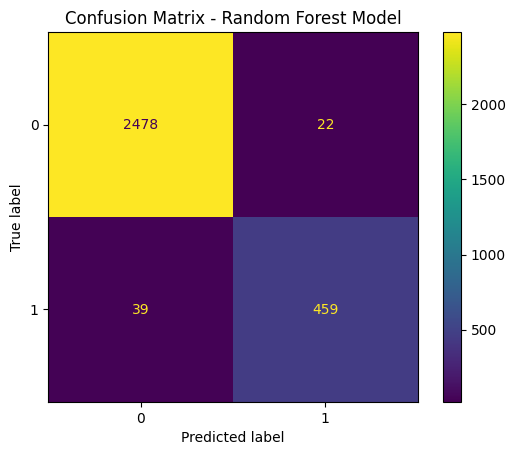

In [47]:
# Generate array of values for confusion matrix
preds = rf1.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_)
disp.plot(values_format='');
plt.title('Confusion Matrix - Random Forest Model')

The model predicts more false negatives (39) than false positives (22). With 2478 true negatives and 459 true positives, the model is good at identifying employees who are not likely to leave, but it still misses a significant number of employees who actually leave the company. There is room for improvement in detecting employees at risk of leaving.

## **Overall Conclusion**

Although both models perform well, the **Random Forest model** is generally more reliable and better suited for this classification task due to its balanced performance and increased generalization power. It would be a strong candidate for deployment in a real-world setting.

The Decision Tree model, while effective, tends to overfit and is more sensitive to small variations in the data. On the other hand, Random Forest, with its ensemble approach, provides more robustness and stability, handling a wider variety of data characteristics and reducing the likelihood of overfitting.

Additionally, while both models could benefit from further **feature engineering to reduce false positives and false negatives**, the Random Forest model's ability to capture more complex patterns in the data suggests that it would be more effective in addressing these issues.

Overall, Random Forest delivers superior results, especially in terms of precision, recall, and accuracy, making it the preferred choice for predicting employee attrition.